In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data
import datetime as dt
import pandas_market_calendars as mcal
import plotly.express as px
from sktime.datasets import load_airline
from sktime.forecasting.tbats import TBATS

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data
import datetime as dt
import pandas_market_calendars as mcal
import plotly.express as px
import requests_cache
from pandas_datareader.yahoo.headers import DEFAULT_HEADERS

class StockData:
    '''
    import the data for given stocks
    '''
    def __init__(self, stocks = ["^DJI"], start = "", end = "", period = None):
        self.df = dict()
        if (start) and (end) and period:
            if period != (pd.Timestamp(end)-pd.Timestamp(start)).days:
                raise ValueError("Does not meet the condition that end - start = period")
        if not start:
            start = pd.Timestamp(end)-pd.Timedelta(days = period)
        else:
            start = pd.Timestamp(start)

        if not end:
            end = pd.Timestamp(start)+pd.Timedelta(days = period)
        else:
            end = pd.Timestamp(end)

        self.open_days = StockData.count_open_day(start, end, period)


        self.start_ts = StockData.last_open_day(start)
        self.end_ts = StockData.next_open_day(end)

        expire_after = dt.timedelta(days=3)
        session = requests_cache.CachedSession(cache_name='cache', expire_after=expire_after)
        session.headers = DEFAULT_HEADERS


        
        ### check end time is not after today
        if end > pd.Timestamp.now():
            raise ValueError("The end time is after today")

        ### check start is before end
        if self.start_ts > self.end_ts:
            raise ValueError("The start date is after the end date")
        
        ### add message when start, end are not market open date
        if self.start_ts != start:
            print("The market is not open on the start date, automatically shifted to the last open date which is %s" 
                            %(self.start_ts.strftime("%Y-%m-%d")))
        if self.end_ts != end:
            print("The market is not open on the end date, automatically shifted to the next open date which is %s" 
                            %(self.end_ts.strftime("%Y-%m-%d")))
        
        for name in stocks:
            ### check name is a valid stock name
            try:
                self.df[name] = data.DataReader(name, 'yahoo', self.start_ts, self.end_ts, session = session)
            except:
                raise ValueError("%s is not a valid stock code in the time range (%s, %s)" 
                                 %(name, self.start_ts.strftime("%Y-%m-%d"), self.end_ts.strftime("%Y-%m-%d")))
            self.df[name]["close-open"] = [StockData.diff(x,y)[0] for x,y in zip(self.df[name]["Open"], self.df[name]["Close"])]
            self.df[name]["high-low"] = [abs(StockData.diff(x,y)[0]) for x,y in zip(self.df[name]["High"], self.df[name]["Low"])]
        return
    
    '''
    return the last market open day before the give date
    '''
    def last_open_day(date_ts):
        nyse = mcal.get_calendar("NYSE")
        start =date_ts - dt.timedelta(days = 20) 
        market_days = nyse.valid_days(start, date_ts)
        
        for i in range(20):
            temp = date_ts - dt.timedelta(days = i)
            if temp.tz_localize("UTC") in market_days:
                return temp 
    '''
    return the next market open day after the given date
    '''
    def next_open_day(date_ts):
        nyse = mcal.get_calendar("NYSE")
        end =date_ts + dt.timedelta(days = 20) 
        market_days = nyse.valid_days(date_ts, end)
        
        for i in range(20):
            temp = date_ts + dt.timedelta(days = i)
            if temp.tz_localize("UTC") in market_days:
                return temp 
    
    '''
    return the count of open days in date_range
    '''
    def count_open_day(start , end , period = None):
        ### add test for three parameters, al least two should be not emply. If all parameters are given
        ### they should match
        start_ts = start if start else end - dt.timedelta(days = period-1)
        end_ts = end if end else start + dt.timedelta(days = period-1)
        
        nyse = mcal.get_calendar("NYSE")
        return len(nyse.valid_days(start_ts, end_ts))
        
        
    
    '''
    compute the inflation, return a string of percentage
    '''
    def diff(a,b):
        result = round((b-a)/a, 4)
        return result, str(round(result*100, 2))+"%"
    
    
    
    '''
    get the inflation from start to end
    '''
    def total_inflation(self, stock = [], start = "", end = "", method = "close-open"):
        if not stock:
            stock = list(self.df.keys())
        
        start_ts = StockData.last_open_day(start) if start else self.start_ts
        end_ts = StockData.last_open_day(end) if end else self.end_ts
        
        inflation = dict()
        if method == "close-open":
            for name in stock:
                inflation[name] = StockData.diff(self.df[name].loc[start_ts]["Close"], self.df[name].loc[end_ts]["Open"])[1]
        else:
            for name in stock:
                inflation[name] = StockData.diff(self.df[name].loc[start_ts]["High"], self.df[name].loc[end_ts]["Low"])[1]
        
        return pd.DataFrame(data = inflation, index = ["inflation"])
    
    
    
    '''
    get the inflation for every day
    '''
    def inflation(self, stock = [], start = "", end = "", method = "close-open", in_function = False):
        if not stock:
            stock = list(self.df.keys())
        
        start_ts = StockData.last_open_day(start) if start else self.start_ts
        end_ts = StockData.last_open_day(end) if end else self.end_ts
        date_range = pd.date_range(start_ts, end_ts)
        
        result = pd.DataFrame()
        for name in stock:
            result[name] = self.df[name].loc[self.df[name].index.isin(date_range), :][method]
        
        max_inc_date = result.idxmax()
        max_dec_date = result.idxmin()
        
        if not in_function:
            for name in stock:
                print("The average for %s is: %s \n" %(name, str(round(np.mean(result[name])*100, 2))+"%"))
                print("The max increase/min decrease of %s occured on %s, which is %s \n " 
                  %(name, max_inc_date[name].strftime("%Y-%m-%d"), str(round(result[name].max()*100, 2))+"%"))
                print("The max decrease/min increase of %s occured on %s, which is %s \n" 
                  %(name, max_dec_date[name].strftime("%Y-%m-%d"), str(round(result[name].min()*100, 2))+"%"))
            
        return result
    
    
    '''
    plot the daily inflation
    '''
    def inflation_plot(self, stock = [], start = "", end = "", method = "close-open"):
        df_inflation = self.inflation(stock, start, end, method, in_function = True)
        sns.set()
        plt.figure(figsize = (10, 8))
        
        plt.subplot(1,2,1)
        df_inflation.plot.box()
        plt.title("Box Plot for Inflation")
        
        plt.subplot(1,2,2)
        df_inflation.plot()
        plt.legend()
        plt.title("Plot for the Inflation")
        plt.show()
        
         

    '''
    plot the daily price data
    '''
    def price_plot(self, stock = [], start = "", end = "", method = ["Open", "Close", "High", "Low"]):
        if not stock:
            stock = list(self.df.keys())
        
        ### add message when stock is more than 10
        
        start_ts = StockData.last_open_day(start) if start else self.start_ts
        end_ts = StockData.last_open_day(end) if end else self.end_ts
        
        date_range = pd.date_range(start = start_ts, end = end_ts)
        
        sns.set()
        plt.figure(figsize = (15, 45))
        
        for idx, name in enumerate(stock):
            plt.subplot(5, 1, idx+1)
            df_temp = self.df[name].loc[self.df[name].index.isin(date_range), :]
            for col in method:
                df_temp[col].plot()
            plt.legend()
            plt.title(name)
        plt.show()




In [3]:
data = StockData(["Meta"], start = "2010-01-01", end = "2022-01-01")

The market is not open on the start date, automatically shifted to the last open date which is 2009-12-31
The market is not open on the end date, automatically shifted to the next open date which is 2022-01-03


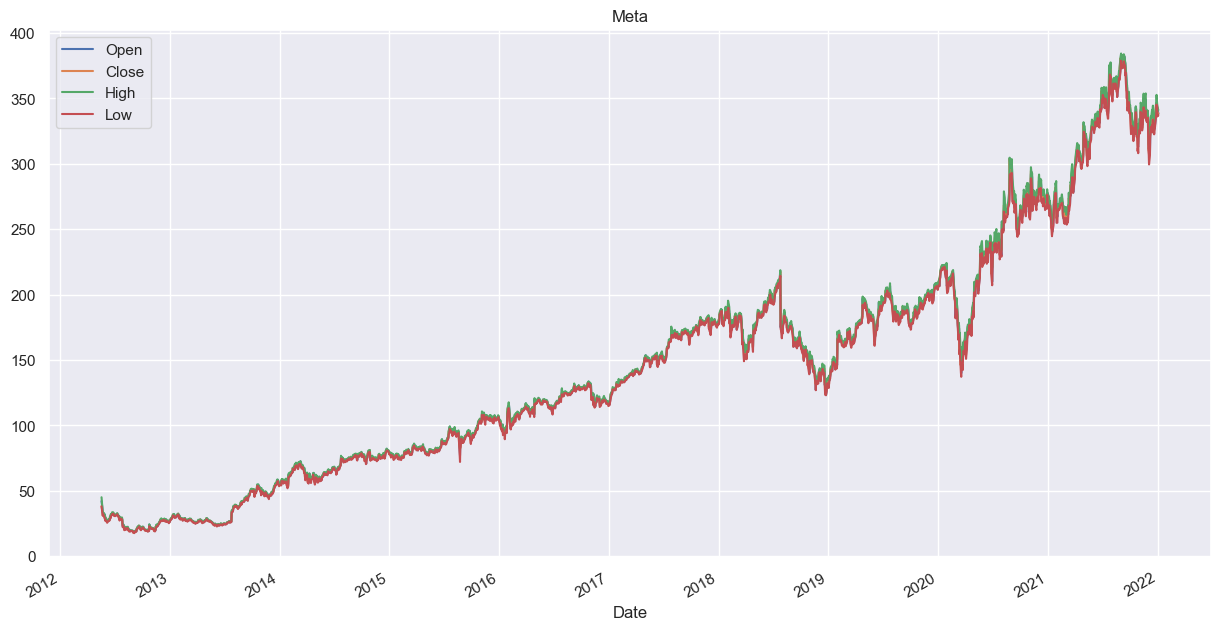

In [7]:
data.price_plot()

In [5]:
from src.StockPrice_visualize import StockData

In [76]:
data[-30:]

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-08-29,267.399994,263.850006,265.850006,265.230011,20338500.0,264.484650
2022-08-30,267.049988,260.660004,266.670013,262.970001,22767100.0,262.230988
2022-08-31,267.109985,261.329987,265.390015,261.470001,24791800.0,260.735199
2022-09-01,260.890015,255.410004,258.869995,260.399994,23263400.0,259.668213
2022-09-02,264.739990,254.470001,261.700012,256.059998,22855400.0,255.340408
2022-09-06,257.829987,251.940002,256.200012,253.250000,21328200.0,252.538300
2022-09-07,258.829987,253.220001,254.699997,258.089996,24126700.0,257.364716
2022-09-08,260.429993,254.789993,257.510010,258.519989,20319900.0,257.793488
2022-09-09,265.230011,260.290009,260.500000,264.459991,22084700.0,263.716797


In [2]:
start_ts = pd.Timestamp("2022-01-01")
end_ts = pd.Timestamp("2022-10-10")
data = data.DataReader("MSFT", 'yahoo', start_ts, end_ts)

In [6]:
y = data["Open"][:-30]

In [80]:
train = y.reset_index()["Open"]
days = y.reset_index()["Date"]

forecaster = TBATS(use_box_cox=True, use_trend=True, sp=5, use_arma_errors=True)
forecaster.fit(train)

TBATS(sp=5, use_box_cox=True, use_trend=True)

In [31]:
train.index[-1]

163

In [79]:
start_day = days.iloc[-1]

In [78]:
pred = pd.Series(dtype = float)

In [66]:
predicted = forecaster.predict(fh = [1])
index_pred, val_pred = predicted.index[0], predicted.iloc[0]

In [77]:
val_real = data.loc[start_day]["Open"]
val_real

265.8500061035156

In [81]:
for _ in range(30):
    start_day = StockData.next_open_day(start_day+pd.Timedelta(days = 1))
    predicted = forecaster.predict(fh = [1])
    index_pred, val_pred = predicted.index[0], predicted.iloc[0]
    pred = pd.concat([pred, pd.Series(data = [val_pred], index = [start_day])])   
    val_real = data.loc[start_day]["Open"]
    forecaster.update(y = pd.Series(data = [val_real], index = [index_pred]))
    print(val_real, val_pred)

265.8500061035156 278.74322471676476
266.6700134277344 267.1436758361029
265.3900146484375 266.84782272887793
258.8699951171875 266.3793559760238
261.70001220703125 259.8298684761175
256.20001220703125 262.55409142190763
254.6999969482422 257.02636380764073
257.510009765625 255.8146209821594
260.5 257.31548700054617
265.7799987792969 260.9252591369134
258.8399963378906 265.3505826866079
253.52999877929688 259.9732591391238
249.77000427246094 254.32365583507254
244.25999450683594 251.58458421997872
242.47000122070312 245.23227768057464
242.07000732421875 244.5377449856058
244.27000427246094 241.54882604026204
237.8699951171875 245.22424201626916
239.5399932861328 238.94557449354554
237.0500030517578 240.4387585529522
239.97999572753906 237.93845917291966
236.80999755859375 240.6037485206501
238.88999938964844 238.40448461637368
238.2899932861328 239.8719026604608
235.41000366210938 239.0594419233071
245.08999633789062 236.16811632553552
245.99000549316406 244.6827137936544
247.929992675

In [87]:
pred_total = pd.concat([y, pred])
data["pred"] = pred_total.values

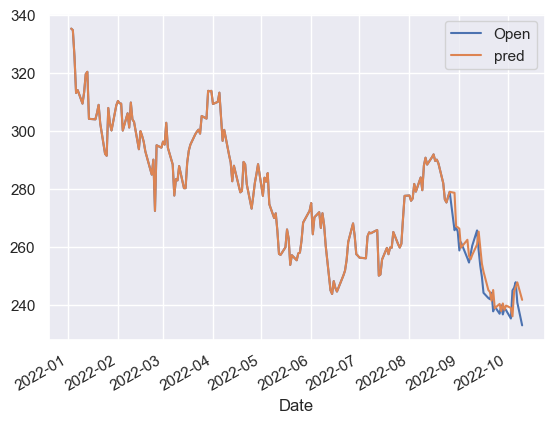

In [92]:
sns.set()
data.loc[:,["Open", "pred"]].plot()
plt.savefig("test.png")
plt.show()

<AxesSubplot:xlabel='Date'>

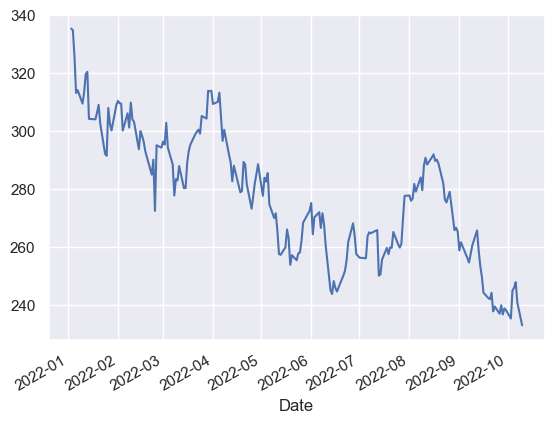

In [94]:
data["Open"].plot()

In [36]:
start_ts = pd.Timestamp("2022-01-01")
end_ts = pd.Timestamp("2022-10-10")
a = data.DataReader("^DJI", 'yahoo', start_ts, end_ts)
a

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-01-03,36595.820312,36246.449219,36321.589844,36585.058594,347930000,36585.058594
2022-01-04,36934.839844,36636.000000,36636.000000,36799.648438,435080000,36799.648438
2022-01-05,36952.648438,36400.390625,36722.601562,36407.109375,462040000,36407.109375
2022-01-06,36464.191406,36200.679688,36409.050781,36236.468750,385890000,36236.468750
2022-01-07,36382.839844,36111.531250,36249.589844,36231.660156,356110000,36231.660156
...,...,...,...,...,...,...
2022-10-04,30325.050781,29826.669922,29826.669922,30316.320312,375640000,30316.320312
2022-10-05,30454.460938,29886.439453,30078.359375,30273.869141,290610000,30273.869141
2022-10-06,30329.609375,29859.339844,30206.130859,29926.939453,306840000,29926.939453


In [66]:
b = data.DataReader("MCD", 'yahoo', start_ts, end_ts)
b

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-01-03,270.730011,265.559998,269.489990,268.579987,2750600.0,264.175964
2022-01-04,271.149994,268.269989,269.500000,268.510010,2506000.0,264.107178
2022-01-05,270.279999,266.899994,269.299988,267.190002,2473000.0,262.808807
2022-01-06,270.760010,267.799988,268.119995,269.690002,2908400.0,265.267822
2022-01-07,270.170013,267.000000,268.559998,267.059998,2209100.0,262.680939
...,...,...,...,...,...,...
2022-10-04,241.050003,236.210007,236.710007,238.500000,3685700.0,238.500000
2022-10-05,240.410004,236.139999,236.910004,239.089996,3033000.0,239.089996
2022-10-06,239.880005,234.460007,239.339996,234.750000,2999200.0,234.750000


In [38]:
b[-10:]

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-09-27,139.419998,134.119995,137.919998,134.399994,30826500,134.399994
2022-09-28,142.029999,134.270004,134.619995,141.610001,32658500,141.610001
2022-09-29,139.839996,135.199997,139.360001,136.410004,38985400,136.410004
2022-09-30,140.990005,135.500000,136.050003,135.679993,33166400,135.679993
2022-10-03,139.619995,136.100006,137.139999,138.610001,27723100,138.610001
2022-10-04,142.389999,139.339996,140.490005,140.279999,34670700,140.279999
2022-10-05,140.210007,134.779999,138.240005,138.979996,27979300,138.979996
2022-10-06,141.449997,136.600006,137.720001,139.070007,36231100,139.070007
2022-10-07,138.289993,132.440002,136.759995,133.449997,33214800,133.449997


In [67]:
y = b["Open"][:-10]

In [74]:
b[-10:]["Open"]

Date
2022-09-27    244.580002
2022-09-28    236.130005
2022-09-29    236.320007
2022-09-30    233.320007
2022-10-03    233.520004
2022-10-04    236.710007
2022-10-05    236.910004
2022-10-06    239.339996
2022-10-07    233.960007
2022-10-10    233.410004
Name: Open, dtype: float64

In [69]:
y = y.reset_index()
train = y["Open"]
train

0      269.489990
1      269.500000
2      269.299988
3      268.119995
4      268.559998
          ...    
179    256.100006
180    255.130005
181    250.389999
182    247.210007
183    245.940002
Name: Open, Length: 184, dtype: float64

In [49]:
forecaster = TBATS(use_box_cox=True, use_trend=True, sp=7, use_arma_errors=True)

In [50]:
forecaster.fit(train)

TBATS(sp=7, use_box_cox=True, use_trend=True)

In [51]:
forecaster.predict(fh = [1,2,3])

164    278.743225
165    278.636357
166    278.532563
Name: Open, dtype: float64

In [64]:
forecaster.update(y = pd.Series(data = [137.139999], index = [188]))

TBATS(sp=7, use_box_cox=True, use_trend=True)

In [65]:
forecaster.predict(fh = [1])

189    137.200348
dtype: float64

In [60]:
temp = load_airline()
temp[[-36]]

Period
1958-01    340.0
Freq: M, Name: Number of airline passengers, dtype: float64

In [63]:
pd.Series(data = [1], index = [2])

2    1
dtype: int64

In [2]:
from src.StockPrice_visualize import StockData

In [4]:
data = StockData(start = "2022-01-01")

The market is not open on the start date, automatically shifted to the last open date which is 2021-12-31


In [5]:
data.start_ts

Timestamp('2021-12-31 00:00:00')

In [40]:
class StockData:
    '''
    import the data for given stocks
    '''
    def __init__(self, stocks = ["MSFT", "AMZN", "AAPL"], start = "2017-01-01", end = "2022-10-31"):
        self.df = dict()
        self.start_ts = StockData.last_open_day(start)
        self.end_ts = StockData.last_open_day(end)
        
        ### check end time is not after today
        if pd.Timestamp(end) > pd.Timestamp.now():
            raise ValueError("The end time is after today")
        
        ### add message when start, end are not market open date
        if self.start_ts != pd.Timestamp(start):
            print("The market is not open on the start date, automatically shifted to the last open date with is %s" 
                            %(self.start_ts.strftime("%Y-%m-%d")))
        if self.end_ts != pd.Timestamp(end):
            print("The market is not open on the end date, automatically shifted to the last open date with is %s" 
                            %(self.end_ts.strftime("%Y-%m-%d")))
        
        for name in stocks:
            ### check name is a valid stock name
            try:
                self.df[name] = data.DataReader(name, 'yahoo', self.start_ts, self.end_ts)
            except:
                raise ValueError("%s is not a valid stock code in the time range (%s, %s)" 
                                 %(name, self.start_ts.strftime("%Y-%m-%d"), self.end_ts.strftime("%Y-%m-%d")))
            self.df[name]["close-open"] = [StockData.diff(x,y)[0] for x,y in zip(self.df[name]["Open"], self.df[name]["Close"])]
            self.df[name]["high-low"] = [abs(StockData.diff(x,y)[0]) for x,y in zip(self.df[name]["High"], self.df[name]["Low"])]
        return
    
    '''
    return the last market open day before the give date
    '''
    def last_open_day(date):
        date_ts = pd.Timestamp(date)
        nyse = mcal.get_calendar("NYSE")
        start =date_ts - dt.timedelta(days = 20) 
        market_days = nyse.valid_days(start, date_ts)
        
        for i in range(20):
            temp = date_ts - dt.timedelta(days = i)
            if temp.tz_localize("UTC") in market_days:
                return temp 
    '''
    return the next market open day after the given date
    '''
    def next_open_day(date):
        date_ts = pd.Timestamp(date)
        nyse = mcal.get_calendar("NYSE")
        end =date_ts + dt.timedelta(days = 20) 
        market_days = nyse.valid_days(date_ts, end)
        
        for i in range(20):
            temp = date_ts + dt.timedelta(days = i)
            if temp.tz_localize("UTC") in market_days:
                return temp 
    
    '''
    return the count of open days in date_range
    '''
    def count_open_day(start = "", end = "", period = None):
        ### add test for three parameters, al least two should be not emply. If all parameters are given
        ### they should match
        start_ts = pd.Timestamp(start) if start else pd.Timestamp(end) - dt.timedelta(days = period-1)
        end_ts = pd.Timestamp(end) if end else pd.Timestamp(start) + dt.timedelta(days = period-1)
        
        nyse = mcal.get_calendar("NYSE")
        return len(nyse.valid_days(start_ts, end_ts))
        
        
    
    '''
    compute the inflation, return a string of percentage
    '''
    def diff(a,b):
        result = round((b-a)/a, 4)
        return result, str(round(result*100, 2))+"%"
    
    
    
    '''
    get the inflation from start to end
    '''
    def total_inflation(self, stock = [], start = "", end = "", method = "close-open"):
        if not stock:
            stock = list(self.df.keys())
        
        start_ts = StockData.last_open_day(start) if start else self.start_ts
        end_ts = StockData.last_open_day(end) if end else self.end_ts
        
        inflation = dict()
        if method == "close-open":
            for name in stock:
                inflation[name] = StockData.diff(self.df[name].loc[start_ts]["Close"], self.df[name].loc[end_ts]["Open"])[1]
        else:
            for name in stock:
                inflation[name] = StockData.diff(self.df[name].loc[start_ts]["High"], self.df[name].loc[end_ts]["Low"])[1]
        
        return pd.DataFrame(data = inflation, index = ["inflation"])
    
    
    
    '''
    get the inflation for every day
    '''
    def inflation(self, stock = [], start = "", end = "", method = "close-open", in_function = False):
        if not stock:
            stock = list(self.df.keys())
        
        start_ts = StockData.last_open_day(start) if start else self.start_ts
        end_ts = StockData.last_open_day(end) if end else self.end_ts
        date_range = pd.date_range(start_ts, end_ts)
        
        result = pd.DataFrame()
        for name in stock:
            result[name] = self.df[name].loc[self.df[name].index.isin(date_range), :][method]
        
        max_inc_date = result.idxmax()
        max_dec_date = result.idxmin()
        
        if not in_function:
            for name in stock:
                print("The average for %s is: %s \n" %(name, str(round(np.mean(result[name])*100, 2))+"%"))
                print("The max increase/min decrease of %s occured on %s, which is %s \n " 
                  %(name, max_inc_date[name].strftime("%Y-%m-%d"), str(round(result[name].max()*100, 2))+"%"))
                print("The max decrease/min increase of %s occured on %s, which is %s \n" 
                  %(name, max_dec_date[name].strftime("%Y-%m-%d"), str(round(result[name].min()*100, 2))+"%"))
            
        return result
    
    
    '''
    plot the daily inflation
    '''
    def inflation_plot(self, stock = [], start = "", end = "", method = "close-open"):
        df_inflation = self.inflation(stock, start, end, method, in_function = True)
        sns.set()
        plt.figure(figsize = (10, 8))
        
        plt.subplot(1,2,1)
        df_inflation.plot.box()
        plt.title("Box Plot for Inflation")
        
        plt.subplot(1,2,2)
        df_inflation.plot()
        plt.legend()
        plt.title("Plot for the Inflation")
        plt.show()
        
         

    '''
    plot the daily price data
    '''
    def price_plot(self, stock = [], start = "", end = "", method = ["Open", "Close", "High", "Low"]):
        if not stock:
            stock = list(self.df.keys())
        
        ### add message when stock is more than 10
        
        start_ts = StockData.last_open_day(start) if start else self.start_ts
        end_ts = StockData.last_open_day(end) if end else self.end_ts
        
        date_range = pd.date_range(start = start_ts, end = end_ts)
        
        sns.set()
        plt.figure(figsize = (15, 45))
        
        for idx, name in enumerate(stock):
            plt.subplot(5, 1, idx+1)
            df_temp = self.df[name].loc[self.df[name].index.isin(date_range), :]
            for col in method:
                df_temp[col].plot()
            plt.legend()
            plt.title(name)
        plt.show()
    
    
    
    
            

In [42]:
model = StockData(["Meta"],start = "2010-01-01", end = "2023-07-04")

ValueError: The end time is after today

In [17]:
nyse = mcal.get_calendar("NYSE")

In [18]:
start_ts = pd.Timestamp("2022-01-03")
end_ts = pd.Timestamp("2022-01-22")
nyse.valid_days(start_ts, end_ts)

DatetimeIndex(['2022-01-03 00:00:00+00:00', '2022-01-04 00:00:00+00:00',
               '2022-01-05 00:00:00+00:00', '2022-01-06 00:00:00+00:00',
               '2022-01-07 00:00:00+00:00', '2022-01-10 00:00:00+00:00',
               '2022-01-11 00:00:00+00:00', '2022-01-12 00:00:00+00:00',
               '2022-01-13 00:00:00+00:00', '2022-01-14 00:00:00+00:00',
               '2022-01-18 00:00:00+00:00', '2022-01-19 00:00:00+00:00',
               '2022-01-20 00:00:00+00:00', '2022-01-21 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)

In [5]:
StockData.last_open_day("2017-01-01") == pd.Timestamp("2016-12-30")

True

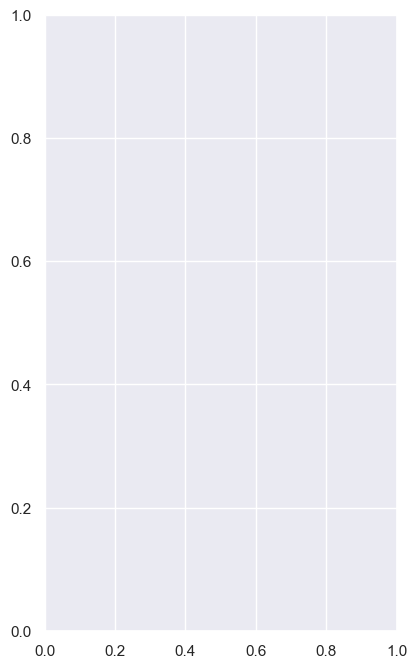

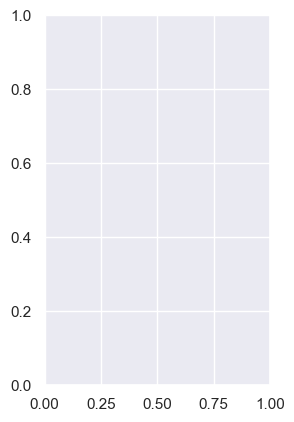

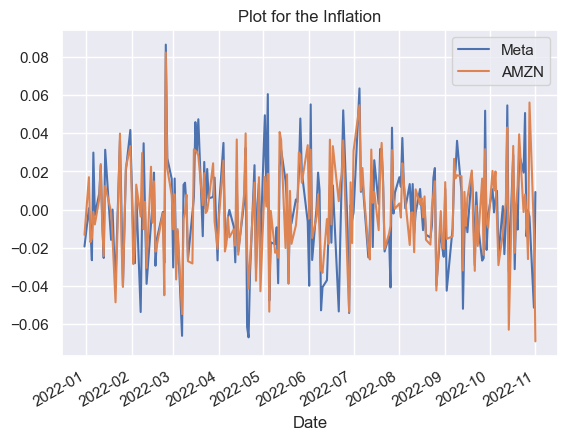

In [464]:
model.inflation_plot()

In [418]:
temp1 = temp[['Meta']].reset_index()[['Meta']]
temp1['C'] = 'Meta'
temp1.columns = [["change",'C']]
temp2 = temp[['AMZN']].reset_index()[['AMZN']]
temp2['C'] = 'AMZN'
temp2.columns = [["change",'C']]

In [441]:
temp3 = pd.concat([temp1,temp2], axis = 0)
temp3.reset_index(drop = True,inplace=True)

<AxesSubplot:>

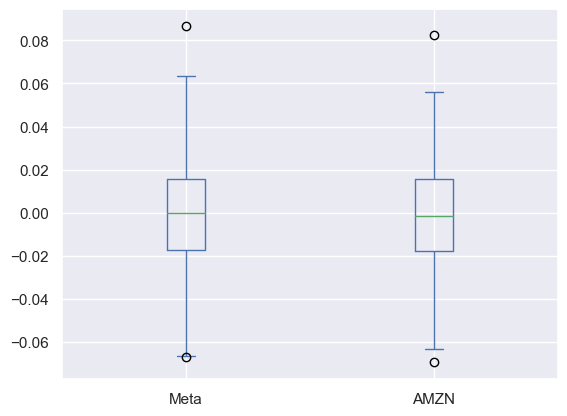

In [451]:
temp.plot.box()

In [461]:
np.mean(temp)

Meta   -0.000736
AMZN   -0.000709
dtype: float64

In [388]:
model.total_inflation()

,Meta,AMZN
inflation,-71.95%,-37.62%


In [378]:
temp

,Meta,AMZN
Date,,
2021-12-31,-0.0194,-0.0133
2022-01-03,0.0007,0.0170
2022-01-04,-0.0101,-0.0171
2022-01-05,-0.0266,-0.0151
2022-01-06,0.0299,-0.0012
...,...,...
2022-10-26,-0.0141,-0.0029
2022-10-27,-0.0004,-0.0260
2022-10-28,-0.0038,0.0562


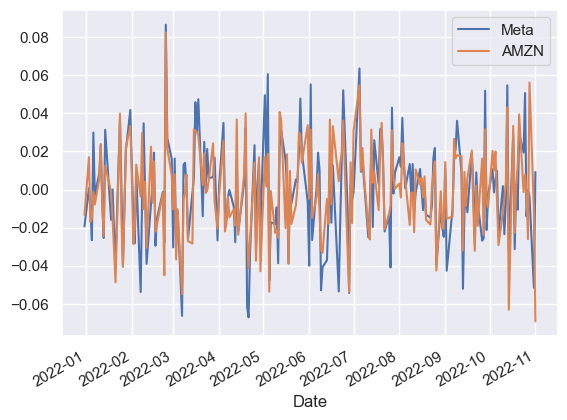

In [387]:
temp.plot()
plt.show()

In [343]:
model.total_inflation()

,Meta,AMZN
inflation,-71.95%,-37.62%


In [338]:
model.df["Meta"].loc[model.df["Meta"].index.isin(date_range),:]["close-open"]

Date
2022-01-03    0.0007
2022-01-04   -0.0101
2022-01-05   -0.0266
2022-01-06    0.0299
2022-01-07   -0.0029
               ...  
2022-04-04    0.0350
2022-04-05   -0.0096
2022-04-06   -0.0159
2022-04-07   -0.0044
2022-04-08   -0.0002
Name: close-open, Length: 68, dtype: float64

In [177]:
model.df["AMZN"].columns

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')

In [143]:
model.total_inflation()#method = "high-low")

,Meta
inflation,-72.25%


In [269]:
#pd.Timestamp("2020-09-28", tz = "UTC") in  nyse.valid_days("2020-01-01", pd.Timestamp("2020-10-10"))
s = pd.Timestamp("2020-09-28")
s.tz_localize("UTC") in nyse.valid_days("2020-01-01", pd.Timestamp("2020-10-10"))

True

In [54]:
#StockData.last_open_day("2017-01-08")
StockData.next_open_day("2017-01-01")

Timestamp('2017-01-03 00:00:00+0000', tz='UTC')

In [272]:
df1 = nyse.valid_days(pd.Timestamp("2016-12-20"), "2017-01-10")
df1

DatetimeIndex(['2016-12-20 00:00:00+00:00', '2016-12-21 00:00:00+00:00',
               '2016-12-22 00:00:00+00:00', '2016-12-23 00:00:00+00:00',
               '2016-12-27 00:00:00+00:00', '2016-12-28 00:00:00+00:00',
               '2016-12-29 00:00:00+00:00', '2016-12-30 00:00:00+00:00',
               '2017-01-03 00:00:00+00:00', '2017-01-04 00:00:00+00:00',
               '2017-01-05 00:00:00+00:00', '2017-01-06 00:00:00+00:00',
               '2017-01-09 00:00:00+00:00', '2017-01-10 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)

In [293]:
StockData.diff(1,2)

(1.0, '100.0%')

In [307]:
date_range = pd.date_range("2022-01-01", "2022-04-08")

In [182]:
df = data.DataReader("AMZN", 'yahoo', "2017-01-01", "2022-10-20")

In [296]:
df["close-open"] = [StockData.diff(x,y)[0] for x,y in zip(df["Close"], df["Open"])]

In [319]:
s = pd.DataFrame().append(df.loc[df.index.isin(date_range),:]["close-open"], ignore_index = True)

In [325]:
t1 = pd.DataFrame()
t2 = df.loc[df.index.isin(date_range),:]["close-open"]

In [326]:
t1["A"] = t2

Index(['A'], dtype='object')

In [72]:
friday = pd.Timestamp('2017-01-05')

In [111]:
friday.weekday()

3

In [5]:
nyse = mcal.get_calendar('NYSE')

In [282]:
df1 = nyse.valid_days(start_date = "2017-01-01", end_date = "2017-01-10")

In [283]:
now = pd.Timestamp("2017-01-02", tz = "UTC")
df1

DatetimeIndex(['2017-01-03 00:00:00+00:00', '2017-01-04 00:00:00+00:00',
               '2017-01-05 00:00:00+00:00', '2017-01-06 00:00:00+00:00',
               '2017-01-09 00:00:00+00:00', '2017-01-10 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)

In [26]:
now + dt.timedelta(days = 1)

Timestamp('2017-01-03 00:00:00+0000', tz='UTC')

In [115]:
s = {'MSFT': '271.28%', 'AMZN': '170.23%', 'AAPL': '425.2%'}

In [146]:
model.end_ts

Timestamp('2022-11-01 00:00:00')

In [184]:
df_temp = df.iloc[df.index.isin(pd.date_range(start = model.start_ts, end = model.end_ts)),:]

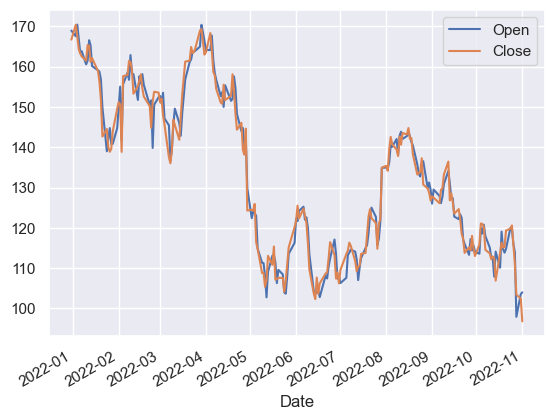

In [345]:
sns.set()
df_temp[["Open", "Close"]].plot(label = ["Open", "Close"])
#plt.legend()
plt.show()

In [165]:
df_temp.columns = [x[0] for x in df_temp.columns]

In [134]:
pd.date_range(start = model.start_ts, periods = 3)

DatetimeIndex(['2021-12-31', '2022-01-01', '2022-01-02'], dtype='datetime64[ns]', freq='D')

In [138]:
data.DataReader(["MSFT"], "yahoo", model.start_ts, "2022-10-30")

Attributes,Adj Close,Close,High,Low,Open,Volume
Symbols,MSFT,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,,
2021-12-31,334.136902,336.320007,339.359985,335.850006,338.510010,18000800.0
2022-01-03,332.577057,334.750000,338.000000,329.779999,335.350006,28865100.0
2022-01-04,326.874359,329.010010,335.200012,326.119995,334.829987,32674300.0
2022-01-05,314.326324,316.380005,326.070007,315.980011,325.859985,40054300.0
2022-01-06,311.842529,313.880005,318.700012,311.489990,313.149994,39646100.0
...,...,...,...,...,...,...
2022-10-24,247.250000,247.250000,247.839996,241.300003,243.759995,24911200.0
2022-10-25,250.660004,250.660004,251.039993,245.830002,247.259995,34775500.0


In [51]:
pow(2,100)

1267650600228229401496703205376

In [15]:
start = "2022-01-01"
end = "2022-01-10"
pd.Timestamp(end) + pd.Timedelta(days = 3)

Timestamp('2022-01-13 00:00:00')

In [53]:
type(a)

int